In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
import seaborn as sns
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.metrics import classification_report, accuracy_score, f1_score
import itertools

In [2]:
#file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025.csv"
file_path = r"C:\Users\jens.nilsen\OneDrive - Bouvet Norge AS\Documents\GitHub\trfkaipoc\data_2022-2025_norge.csv"
df = pd.read_csv(file_path, sep=";")
df = df[df["EGS.VEDTAK.10670"].notna()]
df['Avslag_ind'] = df['EGS.VEDTAK.10670'].apply(lambda x: 1 if x == "Avslag" else 0)
if "Kurvatur, horisontalelement" in df.columns:
    df["Kurvatur, horisontal"] = df["Kurvatur, horisontalelement"]
features = [
    'Avslag_ind',
    "ÅDT, total",
    "ÅDT, andel lange kjøretøy",
    "Fartsgrense",
    "Avkjørsel, holdningsklasse",
    "Funksjonsklasse",
    "Avkjørsler",
    "Trafikkulykker",
    "EGS.BRUKSOMRÅDE.1256", 
    "Kurvatur, horisontal", 
    "Kurvatur, stigning"
]

# Encode categorical features
df_encoded = pd.get_dummies(df[features])
df_encoded=df_encoded.dropna()
df_encoded['sving_ind'] = np.where(df_encoded['Kurvatur, horisontal'].abs() > 99000, 0, 1)
df_encoded['bakke']=df_encoded['Kurvatur, stigning'].abs()
df_encoded['bakke_ind'] = np.where(df_encoded['Kurvatur, stigning'].abs() > 0.1, 1, 0)
df_encoded['sving_sigmoid'] = np.where(df_encoded['Kurvatur, horisontal'].abs() < 99000, 1/(1+np.exp(-0.001*df_encoded['Kurvatur, horisontal'].abs())), 0)
df_encoded['antall_lange_kj']=df_encoded['ÅDT, total']*df_encoded['ÅDT, andel lange kjøretøy']/100
df_encoded = df_encoded.drop(['Kurvatur, horisontal', 'Kurvatur, stigning'], axis=1)

In [13]:
y = df_encoded['Avslag_ind']        # target
X = df_encoded.drop(columns=['Avslag_ind'])  # all other columns
X.shape

(856, 30)

C:\Users\jens.nilsen\AppData\Local\Temp\ipykernel_9372\2443577993.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


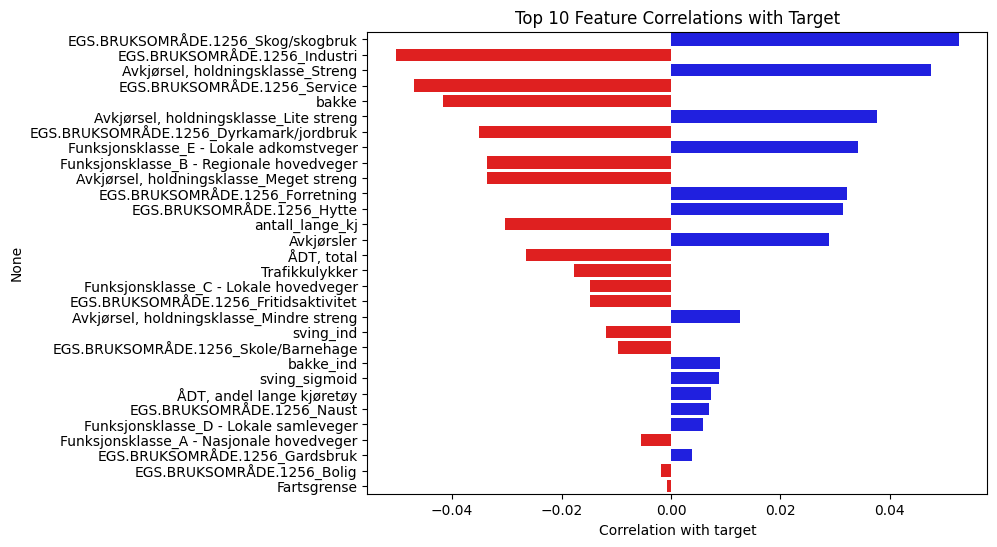

EGS.BRUKSOMRÅDE.1256_Skog/skogbruk          0.052685
EGS.BRUKSOMRÅDE.1256_Industri              -0.050331
Avkjørsel, holdningsklasse_Streng           0.047524
EGS.BRUKSOMRÅDE.1256_Service               -0.046945
bakke                                      -0.041676
Avkjørsel, holdningsklasse_Lite streng      0.037662
EGS.BRUKSOMRÅDE.1256_Dyrkamark/jordbruk    -0.035006
Funksjonsklasse_E - Lokale adkomstveger     0.034159
Funksjonsklasse_B - Regionale hovedveger   -0.033570
Avkjørsel, holdningsklasse_Meget streng    -0.033534
EGS.BRUKSOMRÅDE.1256_Forretning             0.032095
EGS.BRUKSOMRÅDE.1256_Hytte                  0.031459
antall_lange_kj                            -0.030251
Avkjørsler                                  0.028891
ÅDT, total                                 -0.026585
Trafikkulykker                             -0.017732
Funksjonsklasse_C - Lokale hovedveger      -0.014767
EGS.BRUKSOMRÅDE.1256_Fritidsaktivitet      -0.014748
Avkjørsel, holdningsklasse_Mindre streng    0.

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
numeric_X = X.select_dtypes(include=np.number)

# Remove columns with zero variance
numeric_X = numeric_X.loc[:, numeric_X.std() != 0]

# Fill missing values if any
numeric_X = numeric_X.fillna(0)
y_clean = y.fillna(0)

# Compute correlation with target
correlations = X.apply(lambda col: col.corr(y))

# Drop NaN correlations
correlations = correlations.dropna()

# Take top 10 absolute correlations
top10 = correlations.reindex(correlations.abs().sort_values(ascending=False).index)[:30]

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x=top10.values,
    y=top10.index,
    palette=['red' if val < 0 else 'blue' for val in top10.values]
)
plt.xlabel("Correlation with target")
plt.title("Top 10 Feature Correlations with Target")
plt.show()
top10

In [23]:
correlations.shape

(10,)

In [5]:
poly = PolynomialFeatures(10, include_bias=False, interaction_only=True) 
X = pd.DataFrame(poly.fit_transform(X),columns=poly.get_feature_names_out(X.columns))
X.shape

MemoryError: Unable to allocate 338. GiB for an array with shape (856, 53009101) and data type float64

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns only
numeric_X = X.select_dtypes(include=np.number)

# Remove columns with zero variance
numeric_X = numeric_X.loc[:, numeric_X.std() != 0]

# Fill missing values if any
numeric_X = numeric_X.fillna(0)
y_clean = y.fillna(0)

# Compute correlation with target
correlations = numeric_X.apply(lambda col: col.corr(y_clean))

# Drop NaN correlations
correlations = correlations.dropna()

# Take top 10 absolute correlations
top10 = correlations.reindex(correlations.abs().sort_values(ascending=False).index)[:10]

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(
    x=top10.values,
    y=top10.index,
    palette=['red' if val < 0 else 'blue' for val in top10.values]
)
plt.xlabel("Correlation with target")
plt.title("Top 10 Feature Correlations with Target")
plt.show()


In [ ]:
top10